In [1]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision.transforms import v2
%matplotlib inline
import matplotlib.pyplot as plt
from torch import optim
from torch.utils.data import DataLoader

In [2]:
transform = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])
test_data = datasets.MNIST(
    root="data", train=False, download=True, transform=transform
)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)


In [3]:
images, labels = next(iter(test_dataloader))

In [4]:
images.shape


torch.Size([64, 1, 28, 28])

In [5]:
labels.shape

torch.Size([64])

In [26]:
labels

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3])

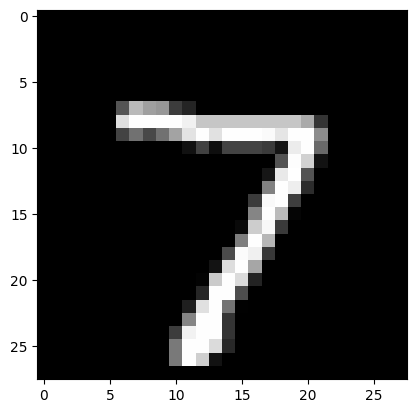

In [7]:
plt.imshow(images[0].reshape(28,28), cmap="gray")
plt.show()

In [8]:
image = images[0]

In [9]:
c, h, w = image.shape

In [10]:
unfolder = nn.Unfold(kernel_size=14, stride=14)
patches = unfolder(images)

In [11]:
patches.shape

torch.Size([64, 196, 4])

In [12]:
rotated = patches.permute(0, 2, 1)

In [13]:
rotated.shape

torch.Size([64, 4, 196])

In [14]:
linear = nn.Linear(196, 64, bias=False)

In [15]:
result = linear(rotated)

In [16]:
result.shape

torch.Size([64, 4, 64])

In [17]:
rotated[0].shape

torch.Size([4, 196])

In [18]:
import models

In [21]:
loss_fn = nn.CrossEntropyLoss()

In [37]:
patchify = models.Patchify()
encoders = nn.ModuleList([models.Encoder() for _ in range(6)])
linear = nn.Linear(64, 10)
patched = patchify(images)
for encoder in encoders:
    patched = encoder(patched)
result = linear(patched)

In [38]:
result.shape

torch.Size([64, 4, 10])

In [39]:
meaned = result.mean(dim=1)

In [40]:
meaned.shape

torch.Size([64, 10])

In [42]:
labels.shape

torch.Size([64])

In [43]:
loss_fn = nn.CrossEntropyLoss()

In [45]:
loss= loss_fn(meaned, labels)

In [46]:
loss.backward()